In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import biolord
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [2]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility


In [3]:
def get_biolord_pred(biolord_model,
                     adata,
                     cell_type_to_check,
                     cov_names,
                     cov_values,
                     cov_values_cf,
                     n_samples_from_source = None,
                    ):
    adata.obs['idx'] = list([i for i in range(len(adata))])
    adata_ = adata[adata.obs['Broad cell type'] == cell_type_to_check].copy()

    source_indices = pd.DataFrame([adata_.obs[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    source_sub_idx = list(adata_[source_indices].obs['idx'])

    source_adata_biolord = adata_[adata_.obs['idx'].isin(source_sub_idx)]
    
    if n_samples_from_source is not None:
        random.seed(0)
        chosen_ids = random.sample(range(len(source_adata_biolord)), n_samples_from_source)
        source_adata_biolord = source_adata_biolord[chosen_ids].copy()
    biolord_preds = biolord_model.compute_prediction_adata(adata, adata_source=source_adata_biolord, target_attributes=cov_names)
    
    pred_idx = pd.DataFrame([biolord_preds.obs[cov_name] == cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    biolord_preds = biolord_preds[pred_idx]

    x_biolord = torch.tensor(biolord_preds.X)
    x_biolord = np.log1p(x_biolord)
                     
    return x_biolord, biolord_preds

In [4]:
def get_ood_avg(adata,  # OOD Adata
                cov_names,
                cov_values: str,
                cov_values_cf: str,
                cats: list[str],):
    adata.X = adata.layers['counts'].copy()
    adata.obs['idx'] = [i for i in range(len(adata))]

    true_indices = pd.DataFrame([adata.obs[cov_name] == cov_values_cf[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    true_idx = list(adata[true_indices].obs['idx'])
    
    source_indices = pd.DataFrame([adata.obs[cov_name] == cov_values[i] for i, cov_name in enumerate(cov_names)]).all(0).values
    source_idx = list(adata[source_indices].obs['idx'])

    true_adata = adata[adata.obs['idx'].isin(true_idx)].copy()
    source_adata = adata[adata.obs['idx'].isin(source_idx)].copy()

    true_x_count = torch.tensor(true_adata.X.toarray())
    cf_x_count = torch.tensor(source_adata.X.toarray())

    x_true = true_x_count
    x_ctrl = cf_x_count

    x_true = np.log1p(x_true)
    x_ctrl = np.log1p(x_ctrl)
    return x_ctrl, x_true

In [5]:
import biolord

import scanpy as sc

adata_1 = sc.read_h5ad('/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/eraslan_preprocessed1212_split_deg.h5ad')
# adata = adata[adata.layers['counts'].sum(1) != 0].copy()
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType']
split_key = 'split_2'

biolord.Biolord.setup_anndata(
    adata=adata_1,
    ordered_attributes_keys=[],
    categorical_attributes_keys=cats,
    layer="counts",
)


module_params = {
    "decoder_width": 1024,
    "decoder_depth": 4,
    "attribute_nn_width": 512,
    "attribute_nn_depth": 2,
    "n_latent_attribute_categorical": 4,
    "gene_likelihood": "nb",
    "reconstruction_penalty": 1e2,
    "unknown_attribute_penalty": 1e1,
    "unknown_attribute_noise_param": 1e-1,
    "attribute_dropout_rate": 0.1,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "seed": 42,
}


model_1 = biolord.Biolord(
    adata=adata_1,
    n_latent=32,
    model_name=f"eraslan_biolord_basicSettings_nb_{split_key}",
    module_params=module_params,
    train_classifiers=False,
    split_key=split_key,
    train_split='train',
    valid_split='val',
    test_split='test',)


trainer_params = {
    "n_epochs_warmup": 0,
    "latent_lr": 1e-4,
    "latent_wd": 1e-4,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

model_1.train(
    max_epochs=500,
    batch_size=512,
    plan_kwargs=trainer_params,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 58/500:  12%|█▏        | 58/500 [03:20<25:31,  3.46s/it, v_num=1, val_generative_mean_accuracy=0.698, val_generative_var_accuracy=0.148, val_biolord_metric=0.423, val_reconstruction_loss=445, val_unknown_attribute_penalty_loss=0.59, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=300, unknown_attribute_penalty_loss=23.9]  
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.434. Signaling Trainer to stop.


In [6]:
import biolord

import scanpy as sc

adata_2 = sc.read_h5ad('/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/eraslan_preprocessed1212_split_deg.h5ad')
adata_2 = adata_2[adata_2.layers['counts'].sum(1) != 0].copy()
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin', 'CoarseCellType']
split_key = 'split_2'

biolord.Biolord.setup_anndata(
    adata=adata_2,
    ordered_attributes_keys=[],
    categorical_attributes_keys=cats,
    layer="counts",
)


module_params = {
    "decoder_width": 1024,
    "decoder_depth": 4,
    "attribute_nn_width": 512,
    "attribute_nn_depth": 2,
    "n_latent_attribute_categorical": 4,
    "gene_likelihood": "nb",
    "reconstruction_penalty": 1e2,
    "unknown_attribute_penalty": 1e1,
    "unknown_attribute_noise_param": 1e-1,
    "attribute_dropout_rate": 0.1,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "seed": 42,
}


model_2 = biolord.Biolord(
    adata=adata_2,
    n_latent=32,
    model_name=f"eraslan_biolord_basicSettings_nb_{split_key}",
    module_params=module_params,
    train_classifiers=False,
    split_key=split_key,
    train_split='train',
    valid_split='val',
    test_split='test',)


trainer_params = {
    "n_epochs_warmup": 0,
    "latent_lr": 1e-4,
    "latent_wd": 1e-4,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

model_2.train(
    max_epochs=500,
    batch_size=512,
    plan_kwargs=trainer_params,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57/500:  11%|█▏        | 57/500 [03:20<25:56,  3.51s/it, v_num=1, val_generative_mean_accuracy=0.673, val_generative_var_accuracy=-0.0114, val_biolord_metric=0.331, val_reconstruction_loss=444, val_unknown_attribute_penalty_loss=0.636, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=300, unknown_attribute_penalty_loss=24]  
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.414. Signaling Trainer to stop.


In [7]:
import gc
gc.collect()

852

In [8]:
cell_type_to_check = 'Epithelial cell (luminal)'

cov_names = ['sex', 'tissue']
cov_values = ['female', 'breast']
cov_values_cf = ['male', 'prostate gland']

In [9]:
x_ctrl, x_true = get_ood_avg(adata_1[adata_1.obs['Broad cell type'] == cell_type_to_check].copy(),
                              cov_names=cov_names,
                              cov_values=cov_values,
                              cov_values_cf=cov_values_cf,
                              cats=cats,
                             )

In [10]:
x_biolord_1, biolord_preds_1 = get_biolord_pred(model_1,
                                            adata_1,
                                            cell_type_to_check,
                                            cov_names=cov_names,
                                            cov_values=cov_values,
                                            cov_values_cf=cov_values_cf,
                                           )

x_biolord_2, biolord_preds_2 = get_biolord_pred(model_2,
                                            adata_2,
                                            cell_type_to_check,
                                            cov_names=cov_names,
                                            cov_values=cov_values,
                                            cov_values_cf=cov_values_cf,
                                           )

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:01,  1.07s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:02,  1.20s/it]
0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:00,  2.29it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:00,  3.89it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


3it [00:00,  3.22it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:01,  3.07it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


5it [00:01,  2.79it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


6it [00:02,  2.85it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


7it [00:02,  2.78it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


8it [00:02,  3.20it/s]


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:01,  1.06s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:02,  1.16s/it]
0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:00,  2.34it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:00,  4.07it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


3it [00:00,  3.28it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:01,  3.17it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


5it [00:01,  2.90it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


6it [00:01,  2.98it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


7it [00:02,  2.84it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


8it [00:02,  3.30it/s]


In [11]:
deg_list = adata_1.uns['rank_genes_groups_split_2']['male_prostate gland']
r2_results = {}
for n_top_deg in [10, 20, 40, 50, 100, 150, 200, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata_1.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata_1.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    x_biolord_1_deg = x_biolord_1[:, degs]
    x_biolord_2_deg = x_biolord_2[:, degs]
    
    r2_mean_base_deg = pearsonr(x_true_deg.mean(0), x_ctrl_deg.mean(0))
    r2_mean_biolord_1_deg = pearsonr(x_true_deg.mean(0), x_biolord_1_deg.mean(0))
    r2_mean_biolord_2_deg = pearsonr(x_true_deg.mean(0), x_biolord_2_deg.mean(0))
    
    r2_var_base_deg = pearsonr(x_true_deg.var(0), x_ctrl_deg.var(0))
    r2_var_biolord_1_deg = pearsonr(x_true_deg.var(0), x_biolord_1_deg.var(0))
    r2_var_biolord_2_deg = pearsonr(x_true_deg.var(0), x_biolord_2_deg.var(0))

    r2_results[str(n_top_deg)] = {}
    r2_results[str(n_top_deg)]['Biolord_1'] = r2_mean_biolord_1_deg[0]
    r2_results[str(n_top_deg)]['Biolord_2'] = r2_mean_biolord_2_deg[0]
    r2_results[str(n_top_deg)]['Control'] = r2_mean_base_deg[0]

    r2_results[str(n_top_deg)]['Biolord_1_var'] = r2_var_biolord_1_deg[0]
    r2_results[str(n_top_deg)]['Biolord_2_var'] = r2_var_biolord_2_deg[0]
    r2_results[str(n_top_deg)]['Control_var'] = r2_var_base_deg[0]
    
r2_results = pd.DataFrame.from_dict(r2_results).T

In [12]:
r2_results

,Biolord_1,Biolord_2,Control,Biolord_1_var,Biolord_2_var,Control_var
10,0.920760,0.263104,-0.385275,0.926288,-0.105031,-0.482408
20,0.866469,0.454122,-0.329255,0.848467,0.339277,-0.314717
40,0.647200,0.364871,-0.212978,0.618543,0.233988,-0.220531
50,0.631373,0.379373,-0.226547,0.618071,0.271262,-0.227404
100,0.399108,0.324209,-0.201024,0.485550,0.357132,-0.184478
150,0.394869,0.313136,-0.165184,0.487107,0.355261,-0.148752
200,0.283677,0.272642,-0.010002,0.326724,0.282378,-0.009468
all,0.587282,0.628757,0.298811,0.649232,0.626572,0.342453


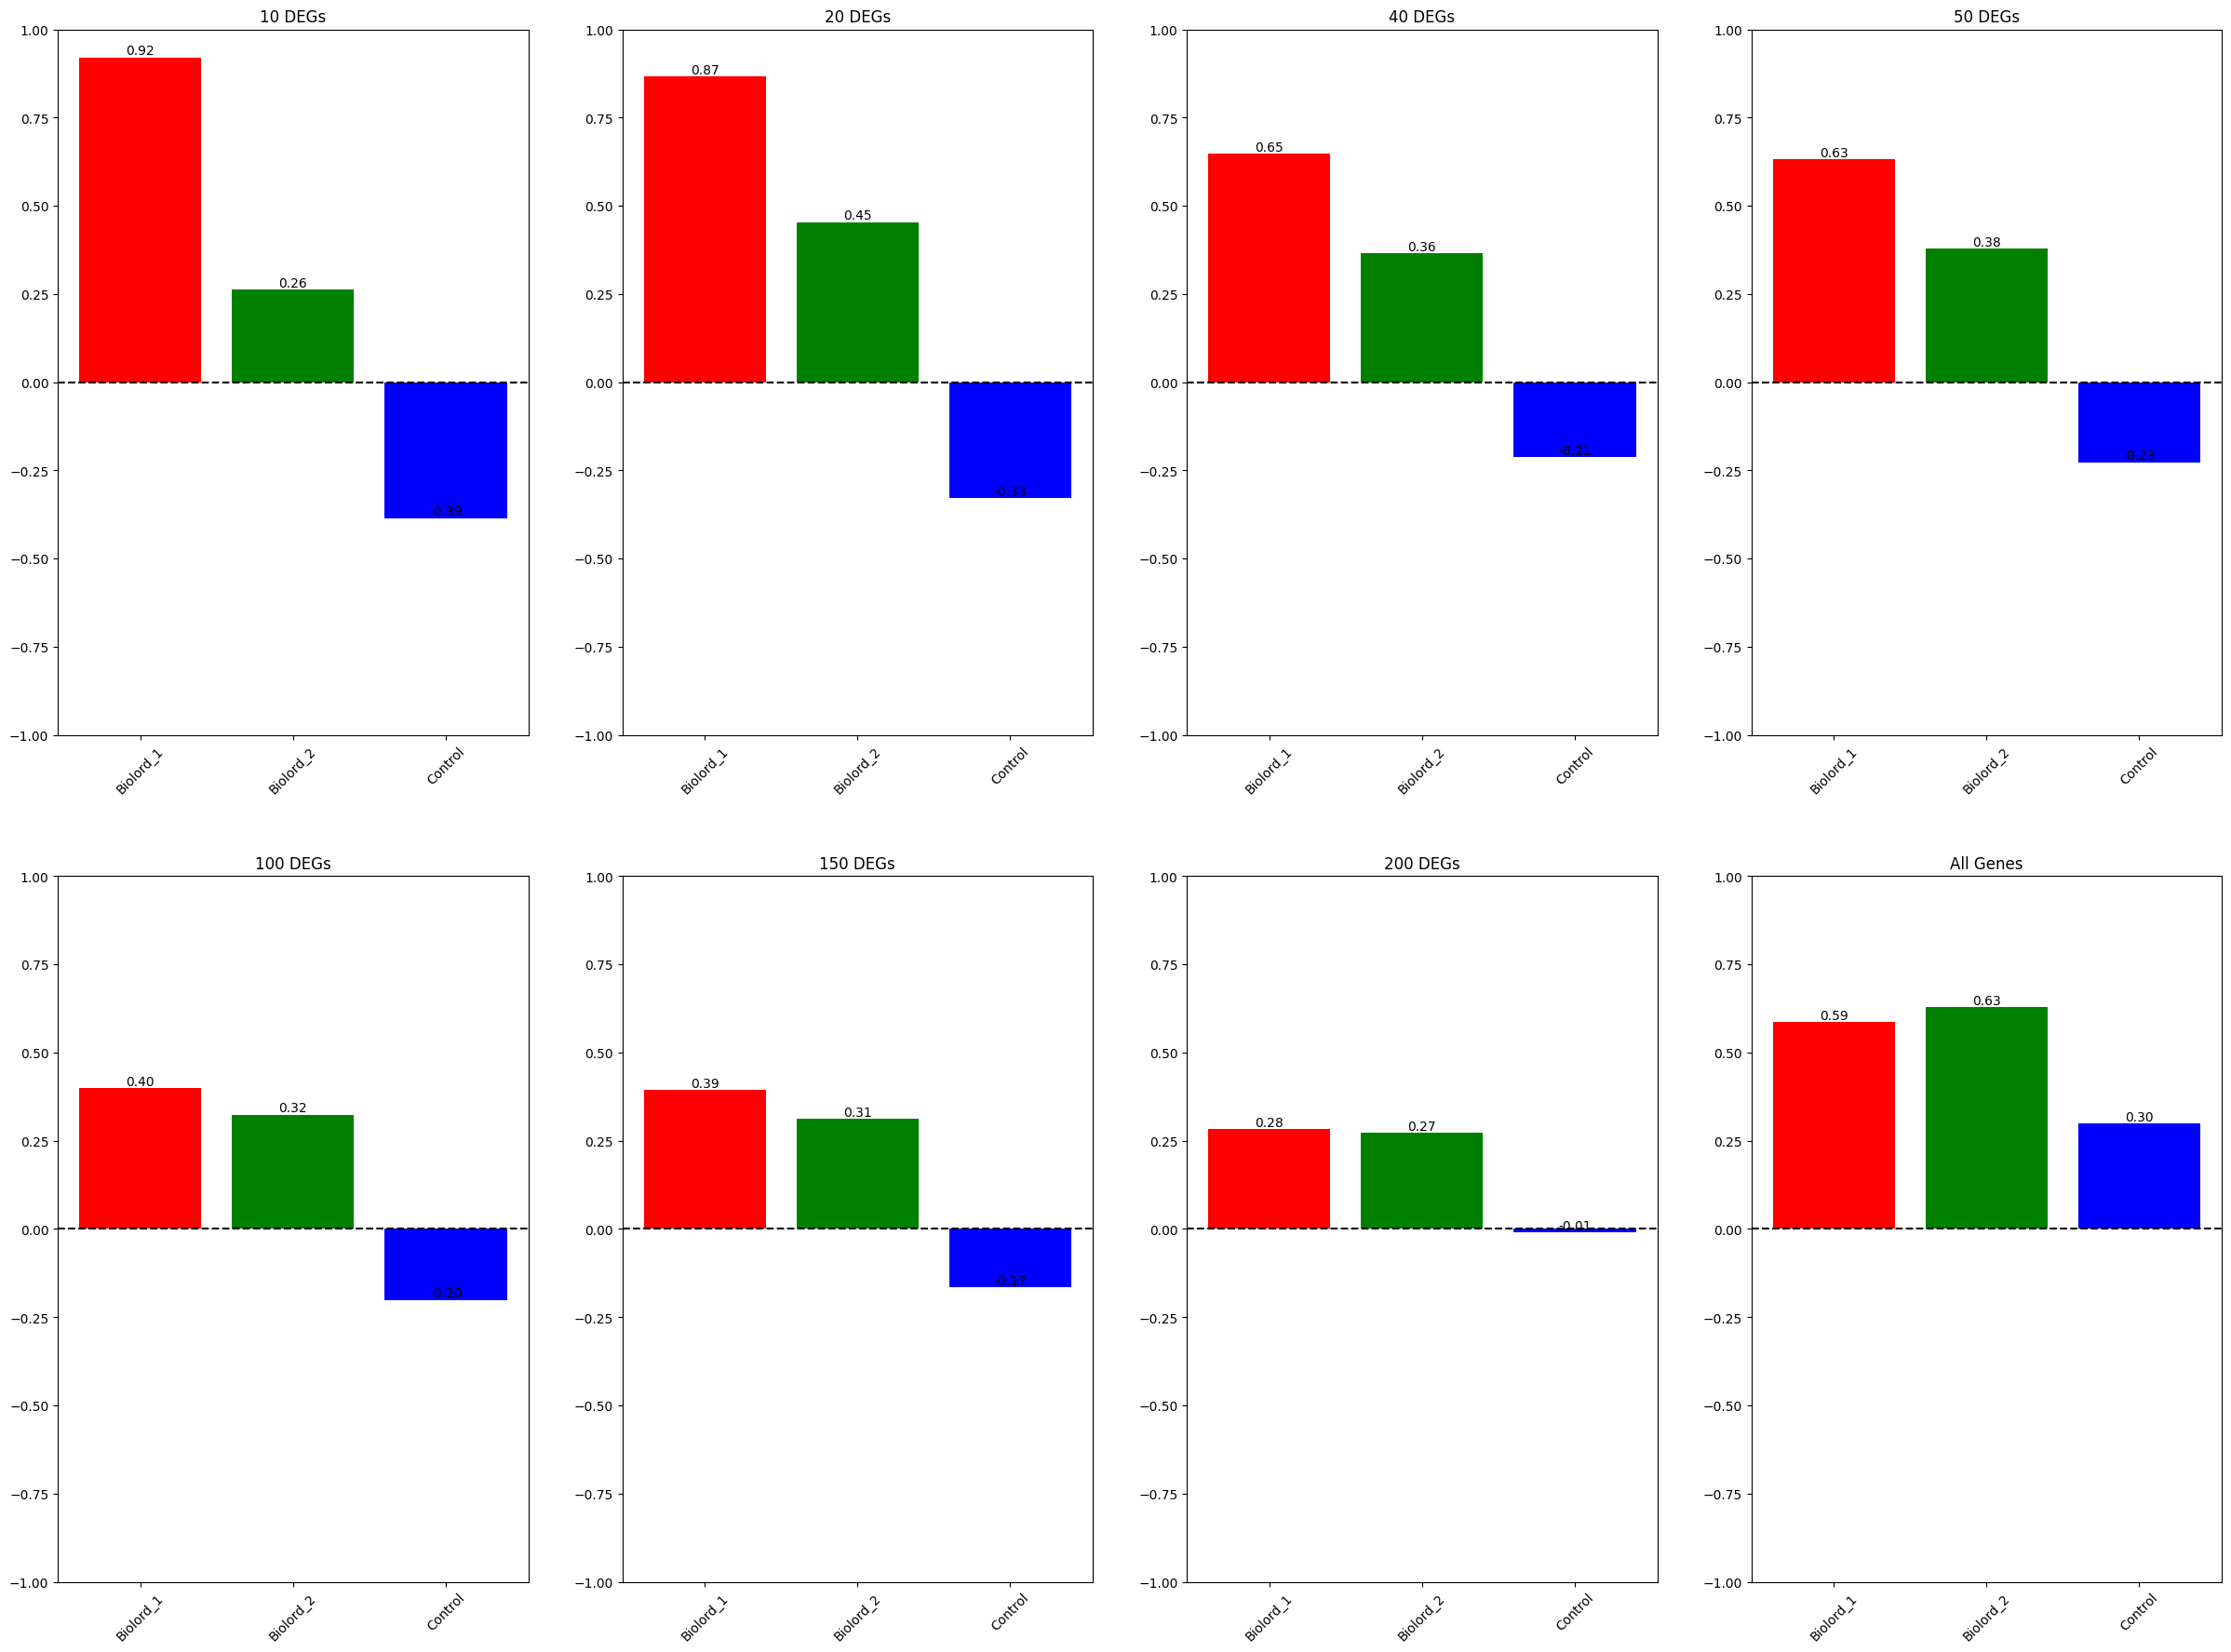

In [13]:
n_rows = r2_results.shape[0]
df = r2_results
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

for i in range(n_rows):
    row = df.iloc[i][:3]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns[:3], rotation=45)  # Setting x-axis labels
    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')  # Setting title
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

# plt.tight_layout()  # Adjust layout to prevent overlap
# fig.tight_layout(rect=[10, 10, 10, 0.95])
# fig.suptitle('Mean Regular Pearson (DEGs are with sex/tissue reference)', y = 1.57)
# plt.title("Mu Regular Pearson")
plt.subplots_adjust(top=1.5)
plt.show()  # Displaying the plot

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history, labels, smoothing_factor=None):
    """
    Plots line graphs for the provided training history dictionary.

    Args:
        history: A dictionary containing the training history metrics.
        smoothing_factor (optional): If provided, a moving average smoothing
                                    is applied to the curves.
    """
    metrics = list(history[0].keys())

    # Create subplots for each metric
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4 * len(metrics)))

    for i, metric in enumerate(metrics):
        for j, hist in enumerate(history):
            values = hist[metric]

            # Apply smoothing if requested
            if smoothing_factor:
                values = [sum(values[max(0, j - smoothing_factor + 1):j + 1]) / smoothing_factor
                          for j in range(len(values))]

            axes[i].plot(values, label=f'{labels[j]}_{metric}')
            axes[i].set_title(f"Training History: {metric}")
            axes[i].set_xlabel("Epoch")
            axes[i].set_ylabel(metric)
            axes[i].legend()
            axes[i].grid(True)

    plt.tight_layout()
    plt.show()


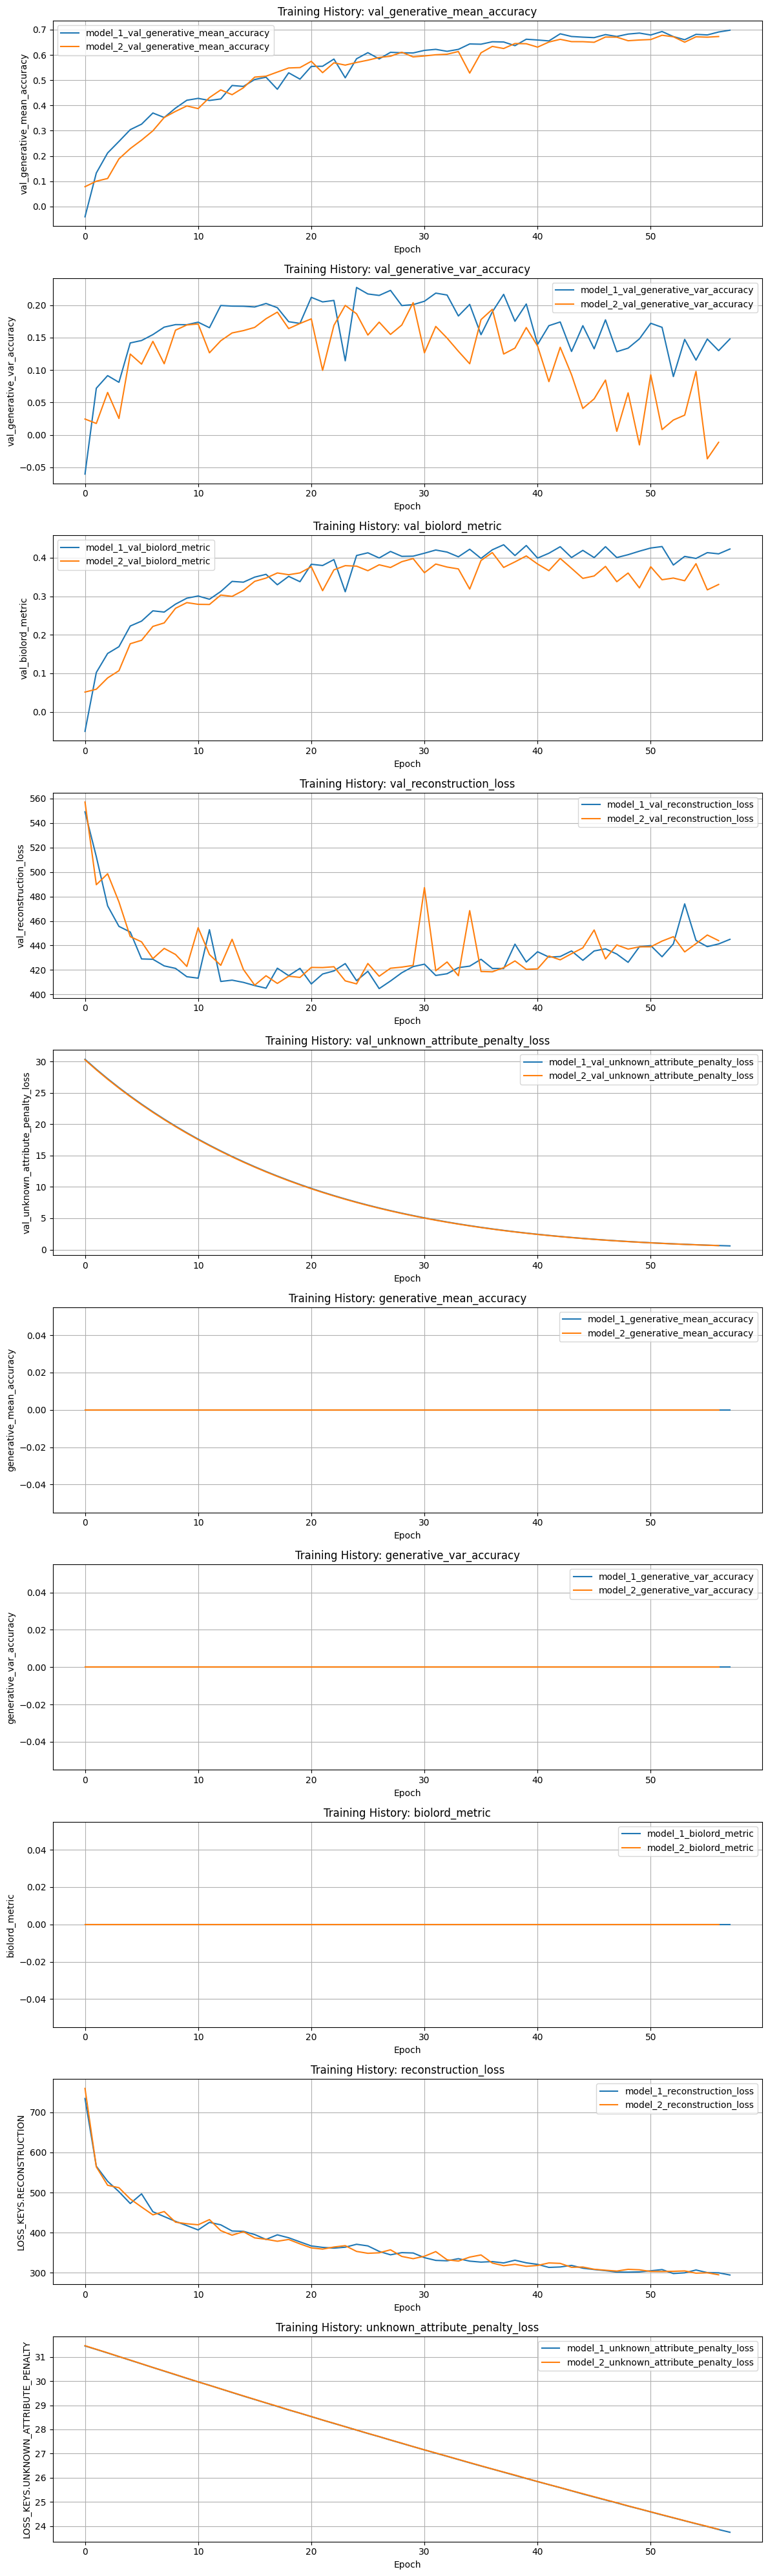

In [15]:
plot_training_history([model_1.history, model_2.history], ['model_1', 'model_2'])

In [16]:
x_biolord_1

tensor([[1.3517e+00, 2.5664e-02, 6.9774e-07,  ..., 2.9941e+00, 1.3768e+00,
         2.7983e+00],
        [6.0157e-01, 7.5847e-03, 1.7668e-07,  ..., 1.9022e+00, 6.3041e-01,
         1.7391e+00],
        [6.0318e-01, 7.1399e-03, 1.4211e-07,  ..., 1.8969e+00, 6.1921e-01,
         1.7207e+00],
        ...,
        [6.5852e-02, 1.3638e-03, 2.0017e-07,  ..., 1.6509e-01, 3.4668e-02,
         1.8622e-01],
        [1.2593e-01, 2.2574e-03, 2.7110e-07,  ..., 2.3166e-01, 4.9807e-02,
         2.6071e-01],
        [1.0349e-01, 2.0393e-03, 2.9609e-07,  ..., 2.4326e-01, 5.2001e-02,
         2.6919e-01]])

In [17]:
x_biolord_2

tensor([[1.5881e+00, 1.2148e-01, 1.6839e-03,  ..., 2.5060e+00, 5.5045e-01,
         2.4705e+00],
        [8.0813e-01, 3.4840e-02, 4.4432e-04,  ..., 1.4637e+00, 1.7934e-01,
         1.4215e+00],
        [8.0482e-01, 3.2069e-02, 4.7372e-04,  ..., 1.3891e+00, 1.6809e-01,
         1.3597e+00],
        ...,
        [1.0844e-01, 1.2238e-03, 1.0929e-05,  ..., 3.2152e-02, 4.4815e-03,
         3.4428e-02],
        [1.7529e-01, 2.0051e-03, 1.9003e-05,  ..., 5.1706e-02, 7.3194e-03,
         5.5561e-02],
        [1.5449e-01, 1.9081e-03, 1.8881e-05,  ..., 5.0673e-02, 7.3233e-03,
         5.4191e-02]])

In [21]:
x_biolord_1.var(0).mean()

tensor(0.0056)

In [22]:
x_biolord_2.var(0).mean()

tensor(0.0070)

In [23]:
x_biolord_1.max()

tensor(4.3801)

In [24]:
x_biolord_2.max()

tensor(3.8150)

In [25]:
x_biolord_1.mean(0)

tensor([2.4034e-01, 4.2170e-03, 3.6263e-07,  ..., 6.5845e-01, 1.6911e-01,
        6.4529e-01])

In [26]:
x_biolord_2.mean(0)

tensor([2.9746e-01, 7.6941e-03, 1.1896e-04,  ..., 3.3908e-01, 4.1828e-02,
        3.3140e-01])

In [27]:
model_1.module.px_r

Parameter containing:
tensor([ 1.5665, -1.0615,  1.4609,  ..., -1.3145,  0.9981,  0.5385],
       device='cuda:0', requires_grad=True)

In [28]:
model_2.module.px_r

Parameter containing:
tensor([-0.7960,  0.4739, -0.2607,  ..., -0.0310, -0.0906,  0.4991],
       device='cuda:0', requires_grad=True)

In [30]:
model_1.module.px_r.mean()

tensor(-0.0338, device='cuda:0', grad_fn=<MeanBackward0>)

In [31]:
model_2.module.px_r.mean()

tensor(-0.0413, device='cuda:0', grad_fn=<MeanBackward0>)

In [32]:
model_1.module.px_r.var()

tensor(0.9811, device='cuda:0', grad_fn=<VarBackward0>)

In [33]:
model_2.module.px_r.var()

tensor(0.9909, device='cuda:0', grad_fn=<VarBackward0>)

In [37]:
torch.concat([x_ctrl, x_true, x_biolord_1, x_biolord_2]).numpy()

array([[1.38629436e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.79175949e+00],
       [6.93147182e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.08435191e-01, 1.22376729e-03, 1.09289285e-05, ...,
        3.21516059e-02, 4.48150048e-03, 3.44284512e-02],
       [1.75292820e-01, 2.00506439e-03, 1.90030278e-05, ...,
        5.17061055e-02, 7.31939496e-03, 5.55605628e-02],
       [1.54494375e-01, 1.90808240e-03, 1.88811300e-05, ...,
        5.06729297e-02, 7.32332468e-03, 5.41913062e-02]], dtype=float32)

In [39]:
obs = ['ctrl']*x_ctrl.shape[0] + ['true']*x_true.shape[0] + ['x_biolord_1']*x_biolord_1.shape[0] + ['x_biolord_2']*x_biolord_2.shape[0]

In [41]:
from anndata import AnnData
results_adata = AnnData(X=torch.concat([x_ctrl, x_true, x_biolord_1, x_biolord_2]).numpy(),
                        obs={'source': obs})

In [42]:
results_adata

AnnData object with n_obs × n_vars = 25654 × 1212
    obs: 'source'

         Falling back to preprocessing with `sc.pp.pca` and default params.


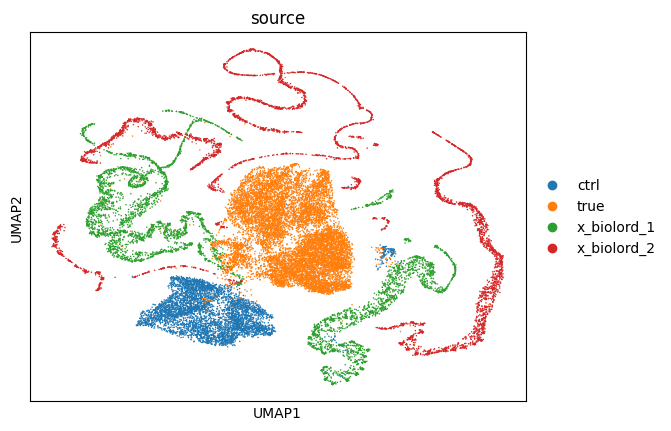

In [43]:
sc.pp.neighbors(results_adata)
sc.tl.umap(results_adata)
sc.pl.umap(results_adata, color='source')